In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Load the dataset
file_path = '/Users/huyong97/personal/benford_law/playgrounds/Obfuscated-MalMem2022.csv'
df = pd.read_csv(file_path)

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nColumn names:")
print(df.columns.tolist())

Dataset shape: (58596, 57)

First few rows:
  Category  pslist.nproc  pslist.nppid  pslist.avg_threads  \
0   Benign            45            17           10.555556   
1   Benign            47            19           11.531915   
2   Benign            40            14           14.725000   
3   Benign            32            13           13.500000   
4   Benign            42            16           11.452381   

   pslist.nprocs64bit  pslist.avg_handlers  dlllist.ndlls  \
0                   0           202.844444           1694   
1                   0           242.234043           2074   
2                   0           288.225000           1932   
3                   0           264.281250           1445   
4                   0           281.333333           2067   

   dlllist.avg_dlls_per_proc  handles.nhandles  handles.avg_handles_per_proc  \
0                  38.500000              9129                    212.302326   
1                  44.127660             11385          

In [10]:
# Separate features and labels
label_column = 'Class'
category_column = 'Category'

# Store labels
labels = df[label_column].copy()
categories = df[category_column].copy() if category_column in df.columns else None

# Get numerical features (exclude label and category columns)
exclude_cols = [label_column]
if category_column in df.columns:
    exclude_cols.append(category_column)

numerical_features = df.drop(columns=exclude_cols)
feature_names = numerical_features.columns.tolist()

print(f"Number of flows: {len(df)}")
print(f"Number of numerical features: {len(feature_names)}")
print(f"\nLabel distribution:")
print(labels.value_counts())

Number of flows: 58596
Number of numerical features: 55

Label distribution:
Class
Benign     29298
Malware    29298
Name: count, dtype: int64


In [11]:
def collapse_value(x):
    """
    Apply value collapsing as per Equation (3) in the paper:
    D_collapsed = |10 × a / 10^int(log(a))|
    
    This transforms decimal numbers to extract the most significant digit
    """
    if pd.isna(x) or x == 0:
        return 0
    
    # Take absolute value to handle negative numbers
    x_abs = abs(x)
    
    # Apply collapsing formula
    try:
        exponent = int(np.floor(np.log10(x_abs)))
        collapsed = abs(10 * x_abs / (10 ** exponent))
        return collapsed
    except:
        return 0

def extract_first_digit(x):
    """
    Extract the first significant digit from a collapsed value
    """
    if pd.isna(x) or x == 0:
        return 0
    
    # Convert to string and extract first character
    x_str = str(int(abs(x)))
    if len(x_str) > 0 and x_str[0].isdigit():
        return int(x_str[0])
    return 0

# Apply preprocessing to each numerical feature
print("Preprocessing features...")
preprocessed_df = pd.DataFrame()

for feature in feature_names:
    # Step 1: Take absolute value (modulus) of negative numbers
    feature_data = numerical_features[feature].apply(lambda x: abs(x) if pd.notna(x) else 0)
    
    # Step 2: Apply value collapsing
    collapsed_data = feature_data.apply(collapse_value)
    
    # Step 3: Extract first significant digit
    first_digits = collapsed_data.apply(extract_first_digit)
    
    preprocessed_df[feature] = first_digits

print("Preprocessing complete!")
print(f"Preprocessed data shape: {preprocessed_df.shape}")

Preprocessing features...
Preprocessing complete!
Preprocessed data shape: (58596, 55)


In [12]:
# Remove features with only zeros or single digit dominance
def check_feature_validity(feature_data):
    """
    Check if feature is valid for Benford's Law analysis
    Returns True if feature has sufficient digit diversity
    """
    # Remove zeros
    non_zero = feature_data[feature_data > 0]
    
    if len(non_zero) == 0:
        return False
    
    # Check digit distribution
    digit_counts = non_zero.value_counts()
    
    # If only one unique digit, remove feature
    if len(digit_counts) == 1:
        return False
    
    # If digit '1' appears in >95% of cases, remove feature
    if 1 in digit_counts.index:
        if digit_counts[1] / len(non_zero) > 0.95:
            return False
    
    return True

# Filter valid features
valid_features = []
for feature in feature_names:
    if check_feature_validity(preprocessed_df[feature]):
        valid_features.append(feature)

print(f"\nOriginal features: {len(feature_names)}")
print(f"Valid features after filtering: {len(valid_features)}")
print(f"Removed features: {len(feature_names) - len(valid_features)}")

# Create filtered dataset
preprocessed_filtered = preprocessed_df[valid_features].copy()


Original features: 55
Valid features after filtering: 44
Removed features: 11


In [13]:
# Calculate frequency of occurrence for each digit (1-9) per flow
def calculate_digit_frequencies(row):
    """
    Calculate the frequency of occurrence of each digit (1-9) for a flow
    """
    # Count occurrences of each digit
    digit_counts = {}
    for digit in range(1, 10):
        digit_counts[digit] = (row == digit).sum()
    
    # Calculate total non-zero elements
    total = sum(digit_counts.values())
    
    # Calculate frequencies
    frequencies = {}
    for digit in range(1, 10):
        frequencies[f'freq_digit_{digit}'] = digit_counts[digit] / total if total > 0 else 0
    
    return pd.Series(frequencies)

print("Calculating digit frequencies per flow...")
frequency_df = preprocessed_filtered.apply(calculate_digit_frequencies, axis=1)

print(f"Frequency matrix shape: {frequency_df.shape}")
print(f"\nSample frequencies for first flow:")
print(frequency_df.iloc[0])

Calculating digit frequencies per flow...
Frequency matrix shape: (58596, 9)

Sample frequencies for first flow:
freq_digit_1    0.139535
freq_digit_2    0.209302
freq_digit_3    0.162791
freq_digit_4    0.116279
freq_digit_5    0.093023
freq_digit_6    0.069767
freq_digit_7    0.046512
freq_digit_8    0.093023
freq_digit_9    0.069767
Name: 0, dtype: float64


Benford's Law Expected Frequencies:
Digit 1: 0.3010
Digit 2: 0.1761
Digit 3: 0.1249
Digit 4: 0.0969
Digit 5: 0.0792
Digit 6: 0.0669
Digit 7: 0.0580
Digit 8: 0.0512
Digit 9: 0.0458


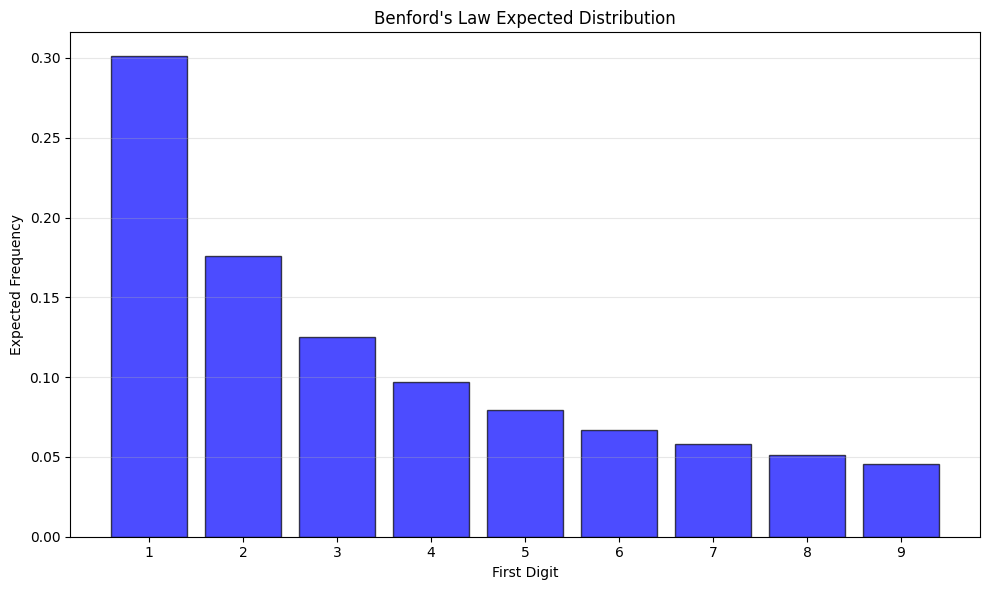

In [14]:
# Benford's Law expected frequencies
benford_expected = {}
for digit in range(1, 10):
    benford_expected[digit] = np.log10(1 + 1/digit)

print("Benford's Law Expected Frequencies:")
for digit, freq in benford_expected.items():
    print(f"Digit {digit}: {freq:.4f}")

# Visualize Benford's Law distribution
plt.figure(figsize=(10, 6))
digits = list(range(1, 10))
expected_freqs = [benford_expected[d] for d in digits]

plt.bar(digits, expected_freqs, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('First Digit')
plt.ylabel('Expected Frequency')
plt.title("Benford's Law Expected Distribution")
plt.xticks(digits)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
# Save preprocessed data
output_data = pd.DataFrame({
    'Category': categories if categories is not None else ['Unknown'] * len(df),
    'Class': labels
})

# Add first digits for each feature
for feature in valid_features:
    output_data[f'{feature}_first_digit'] = preprocessed_filtered[feature]

# Add frequency distributions
output_data = pd.concat([output_data, frequency_df], axis=1)

# Save to file
output_path = '/Users/huyong97/personal/benford_law/playgrounds/preprocessed_MalMem2022.csv'
output_data.to_csv(output_path, index=False)

print(f"\nPreprocessed data saved to: {output_path}")
print(f"Final shape: {output_data.shape}")
print(f"\nValid features for Benford's Law analysis:")
for i, feature in enumerate(valid_features, 1):
    print(f"{i}. {feature}")


Preprocessed data saved to: /Users/huyong97/personal/benford_law/playgrounds/preprocessed_MalMem2022.csv
Final shape: (58596, 55)

Valid features for Benford's Law analysis:
1. pslist.nproc
2. pslist.avg_threads
3. pslist.avg_handlers
4. dlllist.ndlls
5. dlllist.avg_dlls_per_proc
6. handles.nhandles
7. handles.avg_handles_per_proc
8. handles.nfile
9. handles.nevent
10. handles.ndesktop
11. handles.nkey
12. handles.nthread
13. handles.ndirectory
14. handles.nsemaphore
15. handles.nsection
16. handles.nmutant
17. ldrmodules.not_in_load
18. ldrmodules.not_in_init
19. ldrmodules.not_in_mem
20. ldrmodules.not_in_load_avg
21. ldrmodules.not_in_init_avg
22. ldrmodules.not_in_mem_avg
23. malfind.ninjections
24. malfind.commitCharge
25. malfind.protection
26. psxview.not_in_pslist
27. psxview.not_in_ethread_pool
28. psxview.not_in_pspcid_list
29. psxview.not_in_csrss_handles
30. psxview.not_in_session
31. psxview.not_in_deskthrd
32. psxview.not_in_pslist_false_avg
33. psxview.not_in_eprocess_p

In [16]:
# Display summary statistics
print("\n" + "="*80)
print("PREPROCESSING SUMMARY")
print("="*80)
print(f"Total flows: {len(df)}")
print(f"Benign flows: {(labels == 'Benign').sum()}")
print(f"Malicious flows: {(labels != 'Benign').sum()}")
print(f"\nOriginal features: {len(feature_names)}")
print(f"Valid features after preprocessing: {len(valid_features)}")
print(f"Features removed: {len(feature_names) - len(valid_features)}")
print(f"\nOutput columns: {output_data.shape[1]}")
print("="*80)


PREPROCESSING SUMMARY
Total flows: 58596
Benign flows: 29298
Malicious flows: 29298

Original features: 55
Valid features after preprocessing: 44
Features removed: 11

Output columns: 55


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.spatial import distance
import seaborn as sns

# Load preprocessed data
preprocessed_path = '/Users/huyong97/personal/benford_law/playgrounds/preprocessed_MalMem2022.csv'
df = pd.read_csv(preprocessed_path)

print(f"Loaded preprocessed data: {df.shape}")
print(f"\nColumns: {df.columns.tolist()[:10]}...")  # Show first 10 columns

# Separate labels and features
labels = df['Class'].copy()
categories = df['Category'].copy() if 'Category' in df.columns else None

# Get first digit columns (features ending with '_first_digit')
first_digit_cols = [col for col in df.columns if col.endswith('_first_digit')]
print(f"\nNumber of features with first digits: {len(first_digit_cols)}")

Loaded preprocessed data: (58596, 55)

Columns: ['Category', 'Class', 'pslist.nproc_first_digit', 'pslist.avg_threads_first_digit', 'pslist.avg_handlers_first_digit', 'dlllist.ndlls_first_digit', 'dlllist.avg_dlls_per_proc_first_digit', 'handles.nhandles_first_digit', 'handles.avg_handles_per_proc_first_digit', 'handles.nfile_first_digit']...

Number of features with first digits: 44


In [18]:
# Benford's Law expected frequencies
benford_freq = np.array([np.log10(1 + 1/d) for d in range(1, 10)])
benford_dict = {d: np.log10(1 + 1/d) for d in range(1, 10)}

print("Benford's Law Expected Frequencies:")
for d, freq in enumerate(benford_freq, 1):
    print(f"Digit {d}: {freq:.4f}")

Benford's Law Expected Frequencies:
Digit 1: 0.3010
Digit 2: 0.1761
Digit 3: 0.1249
Digit 4: 0.0969
Digit 5: 0.0792
Digit 6: 0.0669
Digit 7: 0.0580
Digit 8: 0.0512
Digit 9: 0.0458


In [19]:
def calculate_observed_frequencies(digit_data):
    """
    Calculate observed frequencies for digits 1-9 from first digit data
    """
    # Remove zeros
    non_zero = digit_data[digit_data > 0]
    
    if len(non_zero) == 0:
        return np.zeros(9)
    
    # Count occurrences of each digit
    frequencies = np.zeros(9)
    for i, digit in enumerate(range(1, 10)):
        frequencies[i] = (non_zero == digit).sum() / len(non_zero)
    
    return frequencies

def kullback_leibler_divergence(observed_freq, expected_freq):
    """
    Calculate KL divergence (Equation 7 in paper)
    D_KL(P||Q) = Σ p(d) * log(p(d)/q(d))
    """
    # Add small epsilon to avoid log(0)
    epsilon = 1e-10
    observed_freq = observed_freq + epsilon
    expected_freq = expected_freq + epsilon
    
    # Normalize
    observed_freq = observed_freq / observed_freq.sum()
    expected_freq = expected_freq / expected_freq.sum()
    
    kl_div = np.sum(observed_freq * np.log(observed_freq / expected_freq))
    return kl_div

def jensen_shannon_divergence(observed_freq, expected_freq):
    """
    Calculate JS divergence (Equation 4 in paper)
    D_JS(P,Q) = 0.5*D(P||M) + 0.5*D(Q||M) where M = 0.5*(P+Q)
    """
    epsilon = 1e-10
    P = observed_freq + epsilon
    Q = expected_freq + epsilon
    
    # Normalize
    P = P / P.sum()
    Q = Q / Q.sum()
    
    # Calculate M (average distribution)
    M = 0.5 * (P + Q)
    
    # Calculate JS divergence
    js_div = 0.5 * np.sum(P * np.log(P / M)) + 0.5 * np.sum(Q * np.log(Q / M))
    return js_div

def mean_absolute_deviation(observed_freq, expected_freq):
    """
    Calculate MAD (Equation 11 in paper)
    MAD = Σ|Fr - Ef| / N where N=9 for first digit
    """
    mad = np.mean(np.abs(observed_freq - expected_freq))
    return mad

def euclidean_distance_metric(observed_freq, expected_freq):
    """
    Calculate Euclidean distance between observed and expected frequencies
    """
    return np.sqrt(np.sum((observed_freq - expected_freq) ** 2))

def pearson_correlation(observed_freq, expected_freq):
    """
    Calculate Pearson correlation coefficient
    """
    corr, _ = stats.pearsonr(observed_freq, expected_freq)
    return corr

def z_statistic(observed_freq, expected_freq, n_observations):
    """
    Calculate Z-statistic (Equation 8 in paper)
    Z = |AP - FE| - (1/2N) / sqrt(FE * (1-FE) / N)
    """
    if n_observations == 0:
        return 0
    
    z_values = []
    for ap, fe in zip(observed_freq, expected_freq):
        if fe == 0 or fe == 1:
            z_values.append(0)
        else:
            numerator = abs(ap - fe) - (1 / (2 * n_observations))
            denominator = np.sqrt((fe * (1 - fe)) / n_observations)
            z = numerator / denominator if denominator > 0 else 0
            z_values.append(abs(z))
    
    return np.sum(z_values)

def kolmogorov_smirnov_statistic(observed_freq, expected_freq):
    """
    Calculate Kolmogorov-Smirnov statistic (Equation 10 in paper)
    D_n = sup_x |F_P(x) - F_Q(x)|
    """
    # Calculate cumulative distributions
    observed_cumsum = np.cumsum(observed_freq)
    expected_cumsum = np.cumsum(expected_freq)
    
    # KS statistic is the maximum absolute difference
    ks_stat = np.max(np.abs(observed_cumsum - expected_cumsum))
    return ks_stat

In [20]:
# Calculate all distance metrics for each feature
print("Calculating distance metrics for all features...")

results = []

for feature_col in first_digit_cols:
    # Extract original feature name
    feature_name = feature_col.replace('_first_digit', '')
    
    # Get first digit data for this feature
    digit_data = df[feature_col].values
    
    # Calculate observed frequencies
    observed_freq = calculate_observed_frequencies(digit_data)
    
    # Calculate number of non-zero observations
    n_obs = len(digit_data[digit_data > 0])
    
    # Calculate all distance metrics
    kl_div = kullback_leibler_divergence(observed_freq, benford_freq)
    js_div = jensen_shannon_divergence(observed_freq, benford_freq)
    mad = mean_absolute_deviation(observed_freq, benford_freq)
    euclidean = euclidean_distance_metric(observed_freq, benford_freq)
    pearson = pearson_correlation(observed_freq, benford_freq)
    z_stat = z_statistic(observed_freq, benford_freq, n_obs)
    ks_stat = kolmogorov_smirnov_statistic(observed_freq, benford_freq)
    
    results.append({
        'feature': feature_name,
        'kl_divergence': kl_div,
        'js_divergence': js_div,
        'mad': mad,
        'euclidean_distance': euclidean,
        'pearson_correlation': pearson,
        'z_statistic': z_stat,
        'ks_statistic': ks_stat,
        'n_observations': n_obs
    })

results_df = pd.DataFrame(results)
print(f"\nCalculated metrics for {len(results_df)} features")
print("\nFirst few results:")
print(results_df.head(10))

Calculating distance metrics for all features...

Calculated metrics for 44 features

First few results:
                        feature  kl_divergence  js_divergence       mad  \
0                  pslist.nproc       1.485517       0.352828  0.161170   
1            pslist.avg_threads       1.065844       0.297918  0.143387   
2           pslist.avg_handlers       1.041695       0.263606  0.134570   
3                 dlllist.ndlls       0.690344       0.210054  0.113529   
4     dlllist.avg_dlls_per_proc       1.186519       0.332366  0.154458   
5              handles.nhandles       0.869098       0.225746  0.113733   
6  handles.avg_handles_per_proc       1.085208       0.276323  0.139004   
7                 handles.nfile       0.850692       0.213225  0.109783   
8                handles.nevent       0.795223       0.218186  0.123806   
9              handles.ndesktop       1.768980       0.393100  0.170567   

   euclidean_distance  pearson_correlation  z_statistic  ks_statistic

In [21]:
# Display summary statistics for each metric
print("\n" + "="*80)
print("DISTANCE METRICS SUMMARY STATISTICS")
print("="*80)
print(results_df.describe())


DISTANCE METRICS SUMMARY STATISTICS
       kl_divergence  js_divergence        mad  euclidean_distance  \
count      44.000000      44.000000  44.000000           44.000000   
mean        0.929029       0.231082   0.117622            0.498264   
std         0.698464       0.151771   0.049590            0.255538   
min         0.031385       0.008460   0.020368            0.065949   
25%         0.434973       0.115868   0.092364            0.357369   
50%         0.795261       0.214552   0.118309            0.457096   
75%         1.116185       0.306530   0.149195            0.622618   
max         2.971730       0.590465   0.210828            1.030974   

       pearson_correlation  z_statistic  ks_statistic  n_observations  
count            44.000000    44.000000     44.000000       44.000000  
mean              0.349512   804.093004      0.393737    53672.295455  
std               0.434197   391.124091      0.194070    12333.633942  
min              -0.434444    29.372900     

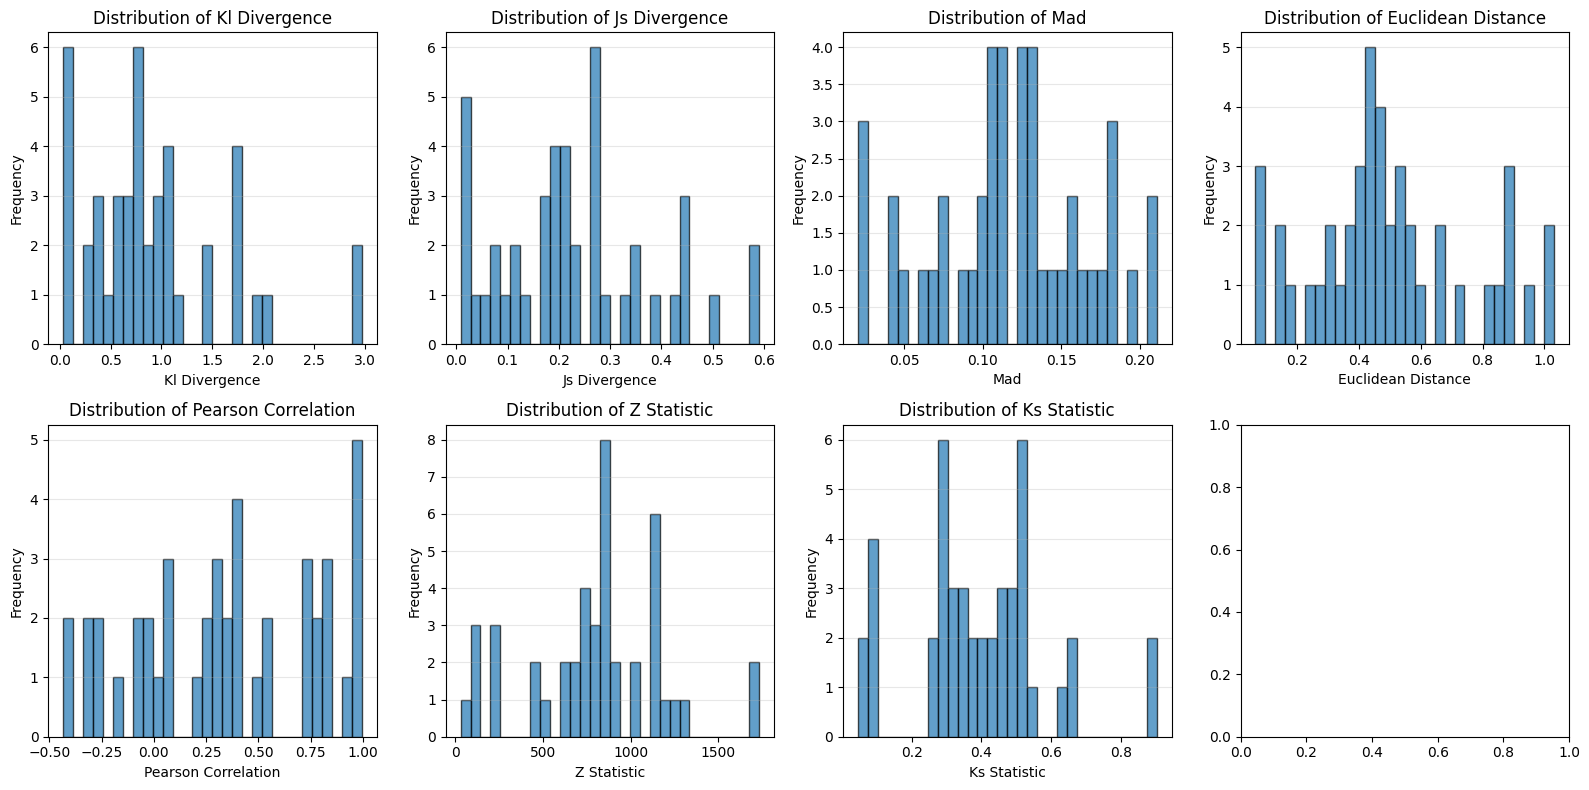

In [22]:
# Visualize distribution of each metric
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

metrics = ['kl_divergence', 'js_divergence', 'mad', 'euclidean_distance', 
           'pearson_correlation', 'z_statistic', 'ks_statistic']

for idx, metric in enumerate(metrics):
    axes[idx].hist(results_df[metric], bins=30, edgecolor='black', alpha=0.7)
    axes[idx].set_xlabel(metric.replace('_', ' ').title())
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'Distribution of {metric.replace("_", " ").title()}')
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/huyong97/personal/benford_law/playgrounds/distance_metrics_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
# Feature Selection based on thresholds from the paper (Section 4.3.1)

# Define thresholds based on paper
THRESHOLDS = {
    'pearson_correlation': 0.85,  # >= 0.85 (high correlation)
    'kl_divergence': 0.10,        # <= 0.10 (low divergence)
    'euclidean_distance': 0.20,   # <= 0.20 (low distance)
    'mad': 1e-5                   # <= 1e-5 (low deviation)
}

print("\n" + "="*80)
print("FEATURE SELECTION BASED ON DISTANCE FUNCTIONS")
print("="*80)

# Select features based on each criterion
selected_features = {}

# 1. Kullback-Leibler Selection
kl_selected = results_df[results_df['kl_divergence'] <= THRESHOLDS['kl_divergence']]['feature'].tolist()
selected_features['KL'] = kl_selected
print(f"\n1. KL Divergence (≤ {THRESHOLDS['kl_divergence']}):")
print(f"   Selected features: {len(kl_selected)}")
print(f"   Features: {kl_selected}")

# 2. Pearson Correlation Selection
pearson_selected = results_df[results_df['pearson_correlation'] >= THRESHOLDS['pearson_correlation']]['feature'].tolist()
selected_features['Pearson'] = pearson_selected
print(f"\n2. Pearson Correlation (≥ {THRESHOLDS['pearson_correlation']}):")
print(f"   Selected features: {len(pearson_selected)}")
print(f"   Features: {pearson_selected}")

# 3. MAD Selection
mad_selected = results_df[results_df['mad'] <= THRESHOLDS['mad']]['feature'].tolist()
selected_features['MAD'] = mad_selected
print(f"\n3. MAD (≤ {THRESHOLDS['mad']}):")
print(f"   Selected features: {len(mad_selected)}")
print(f"   Features: {mad_selected}")

# 4. Euclidean Distance Selection
euclidean_selected = results_df[results_df['euclidean_distance'] <= THRESHOLDS['euclidean_distance']]['feature'].tolist()
selected_features['Euclidean'] = euclidean_selected
print(f"\n4. Euclidean Distance (≤ {THRESHOLDS['euclidean_distance']}):")
print(f"   Selected features: {len(euclidean_selected)}")
print(f"   Features: {euclidean_selected}")


FEATURE SELECTION BASED ON DISTANCE FUNCTIONS

1. KL Divergence (≤ 0.1):
   Selected features: 3
   Features: ['psxview.not_in_pslist', 'psxview.not_in_ethread_pool', 'psxview.not_in_pspcid_list']

2. Pearson Correlation (≥ 0.85):
   Selected features: 6
   Features: ['dlllist.ndlls', 'malfind.protection', 'psxview.not_in_pslist', 'psxview.not_in_ethread_pool', 'psxview.not_in_pspcid_list', 'psxview.not_in_deskthrd_false_avg']

3. MAD (≤ 1e-05):
   Selected features: 0
   Features: []

4. Euclidean Distance (≤ 0.2):
   Selected features: 6
   Features: ['psxview.not_in_pslist', 'psxview.not_in_ethread_pool', 'psxview.not_in_pspcid_list', 'psxview.not_in_pslist_false_avg', 'psxview.not_in_ethread_pool_false_avg', 'psxview.not_in_pspcid_list_false_avg']


In [24]:
# Multi-criteria selection: features meeting at least 2 criteria
print("\n" + "="*80)
print("MULTI-CRITERIA FEATURE SELECTION")
print("="*80)

# Count how many criteria each feature meets
feature_scores = {}
for feature in results_df['feature']:
    score = 0
    row = results_df[results_df['feature'] == feature].iloc[0]
    
    if row['kl_divergence'] <= THRESHOLDS['kl_divergence']:
        score += 1
    if row['pearson_correlation'] >= THRESHOLDS['pearson_correlation']:
        score += 1
    if row['mad'] <= THRESHOLDS['mad']:
        score += 1
    if row['euclidean_distance'] <= THRESHOLDS['euclidean_distance']:
        score += 1
    
    feature_scores[feature] = score

# Add score to results dataframe
results_df['criteria_met'] = results_df['feature'].map(feature_scores)

# Select features meeting at least 2 criteria
multi_criteria_selected = results_df[results_df['criteria_met'] >= 2]['feature'].tolist()
selected_features['Multi_Criteria'] = multi_criteria_selected

print(f"\nFeatures meeting at least 2 criteria: {len(multi_criteria_selected)}")
print(f"Features: {multi_criteria_selected}")

# Show top features by number of criteria met
print("\nTop features by criteria met:")
top_features = results_df.nlargest(10, 'criteria_met')[['feature', 'criteria_met', 'kl_divergence', 'pearson_correlation', 'mad', 'euclidean_distance']]
print(top_features.to_string(index=False))


MULTI-CRITERIA FEATURE SELECTION

Features meeting at least 2 criteria: 3
Features: ['psxview.not_in_pslist', 'psxview.not_in_ethread_pool', 'psxview.not_in_pspcid_list']

Top features by criteria met:
                              feature  criteria_met  kl_divergence  pearson_correlation      mad  euclidean_distance
                psxview.not_in_pslist             3       0.031385             0.990202 0.020368            0.065949
          psxview.not_in_ethread_pool             3       0.035820             0.993682 0.022543            0.083298
           psxview.not_in_pspcid_list             3       0.031409             0.990219 0.020372            0.066007
                        dlllist.ndlls             1       0.690344             0.946069 0.113529            0.423437
                   malfind.protection             1       0.248709             0.968271 0.065411            0.232694
      psxview.not_in_pslist_false_avg             1       0.103292             0.815364 0.04173

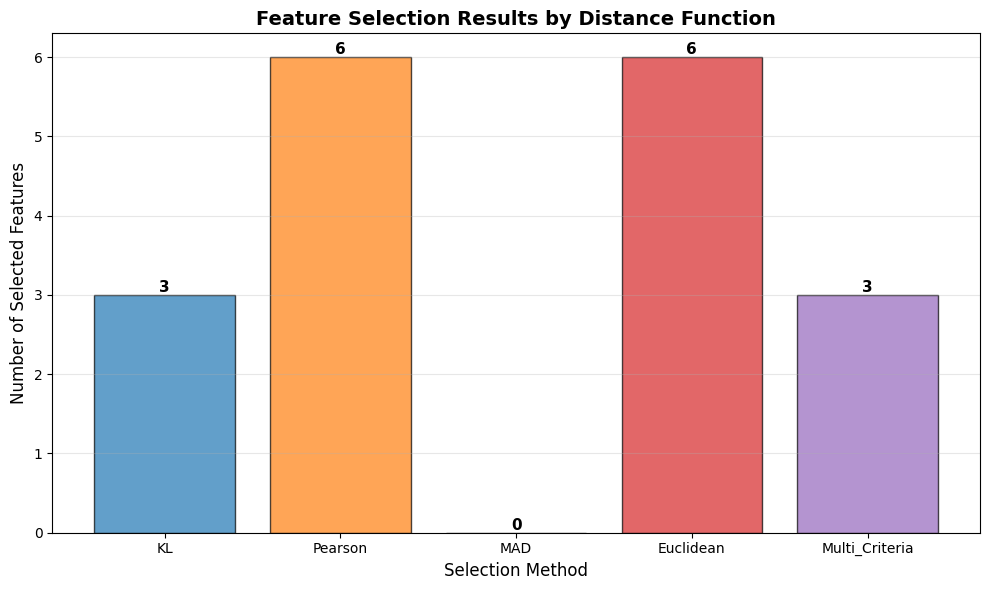

In [25]:
# Visualize selected features by each method
fig, ax = plt.subplots(figsize=(10, 6))

selection_methods = ['KL', 'Pearson', 'MAD', 'Euclidean', 'Multi_Criteria']
selection_counts = [len(selected_features[method]) for method in selection_methods]

bars = ax.bar(selection_methods, selection_counts, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'], 
              edgecolor='black', alpha=0.7)

ax.set_ylabel('Number of Selected Features', fontsize=12)
ax.set_xlabel('Selection Method', fontsize=12)
ax.set_title('Feature Selection Results by Distance Function', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('/Users/huyong97/personal/benford_law/playgrounds/feature_selection_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


Creating feature selection heatmap...


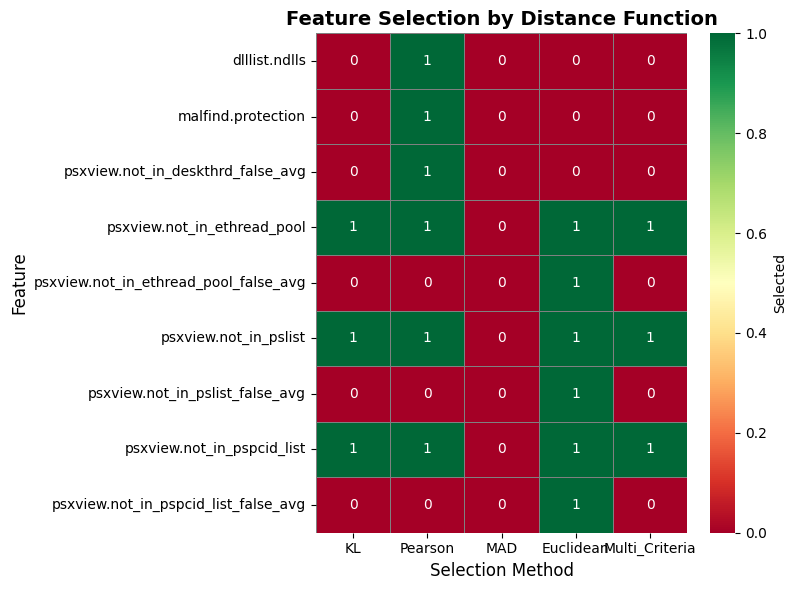

In [26]:
# Create a heatmap showing which features are selected by which methods
print("\nCreating feature selection heatmap...")

# Create a matrix showing which features are selected by which method
all_selected = set()
for features in selected_features.values():
    all_selected.update(features)

selection_matrix = pd.DataFrame(0, index=sorted(all_selected), columns=selection_methods)

for method in selection_methods:
    for feature in selected_features[method]:
        selection_matrix.loc[feature, method] = 1

# Plot heatmap
plt.figure(figsize=(8, max(6, len(all_selected) * 0.3)))
sns.heatmap(selection_matrix, cmap='RdYlGn', cbar_kws={'label': 'Selected'}, 
            linewidths=0.5, linecolor='gray', annot=True, fmt='d')
plt.title('Feature Selection by Distance Function', fontsize=14, fontweight='bold')
plt.xlabel('Selection Method', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('/Users/huyong97/personal/benford_law/playgrounds/feature_selection_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
# Save detailed results
output_path = '/Users/huyong97/personal/benford_law/playgrounds/feature_selection_results.csv'
results_df.to_csv(output_path, index=False)
print(f"\nDetailed results saved to: {output_path}")

# Save selected features for each method
for method, features in selected_features.items():
    method_path = f'/Users/huyong97/personal/benford_law/playgrounds/selected_features_{method.lower()}.txt'
    with open(method_path, 'w') as f:
        f.write(f"Selected features using {method} method:\n")
        f.write(f"Total: {len(features)}\n\n")
        for feature in features:
            f.write(f"{feature}\n")
    print(f"Saved {method} selected features to: {method_path}")


Detailed results saved to: /Users/huyong97/personal/benford_law/playgrounds/feature_selection_results.csv
Saved KL selected features to: /Users/huyong97/personal/benford_law/playgrounds/selected_features_kl.txt
Saved Pearson selected features to: /Users/huyong97/personal/benford_law/playgrounds/selected_features_pearson.txt
Saved MAD selected features to: /Users/huyong97/personal/benford_law/playgrounds/selected_features_mad.txt
Saved Euclidean selected features to: /Users/huyong97/personal/benford_law/playgrounds/selected_features_euclidean.txt
Saved Multi_Criteria selected features to: /Users/huyong97/personal/benford_law/playgrounds/selected_features_multi_criteria.txt


In [28]:
# Compare with paper's results (Table 15)
print("\n" + "="*80)
print("COMPARISON WITH PAPER'S SELECTED FEATURES (Table 15)")
print("="*80)

paper_features = {
    'KL': ['handles.nsection', 'malfind.commitCharge', 'malfind.protection', 
           'psxview.not_in_session', 'psxview.not_in_session_false_avg'],
    'Pearson': ['pslist.nppid', 'dlllist.ndlls', 'handles.ntimer', 'malfind.protection',
                'malfind.uniqueInjections', 'malfind.commitCharge', 
                'psxview.not_in_session_false_avg'],
    'MAD': ['handles.nhandles', 'handles.nfile', 'handles.nthread', 'handles.ntimer',
            'handles.nsection', 'ldrmodules.not_in_init', 
            'psxview.not_in_deskthrd_false_avg'],
    'Euclidean': ['handles.nthread', 'handles.nsection', 'malfind.protection',
                  'psxview.not_in_session_false_avg', 'ldrmodules.not_in_init',
                  'malfind.commitCharge', 'psxview.not_in_csrss_handles_false_avg']
}

for method in ['KL', 'Pearson', 'MAD', 'Euclidean']:
    print(f"\n{method} Method:")
    print(f"  Paper's selected: {len(paper_features[method])}")
    print(f"  Our selection: {len(selected_features[method])}")
    
    # Find overlap
    overlap = set(paper_features[method]) & set(selected_features[method])
    print(f"  Overlap: {len(overlap)} features")
    if overlap:
        print(f"  Common features: {list(overlap)}")


COMPARISON WITH PAPER'S SELECTED FEATURES (Table 15)

KL Method:
  Paper's selected: 5
  Our selection: 3
  Overlap: 0 features

Pearson Method:
  Paper's selected: 7
  Our selection: 6
  Overlap: 2 features
  Common features: ['malfind.protection', 'dlllist.ndlls']

MAD Method:
  Paper's selected: 7
  Our selection: 0
  Overlap: 0 features

Euclidean Method:
  Paper's selected: 7
  Our selection: 6
  Overlap: 0 features


In [29]:
# Let's examine the actual metric values for the paper's selected features
print("="*80)
print("INVESTIGATING METRIC VALUES FOR PAPER'S SELECTED FEATURES")
print("="*80)

paper_features_all = {
    'KL': ['handles.nsection', 'malfind.commitCharge', 'malfind.protection', 
           'psxview.not_in_session', 'psxview.not_in_session_false_avg'],
    'Pearson': ['pslist.nppid', 'dlllist.ndlls', 'handles.ntimer', 'malfind.protection',
                'malfind.uniqueInjections', 'malfind.commitCharge', 
                'psxview.not_in_session_false_avg'],
    'MAD': ['handles.nhandles', 'handles.nfile', 'handles.nthread', 'handles.ntimer',
            'handles.nsection', 'ldrmodules.not_in_init', 
            'psxview.not_in_deskthrd_false_avg'],
    'Euclidean': ['handles.nthread', 'handles.nsection', 'malfind.protection',
                  'psxview.not_in_session_false_avg', 'ldrmodules.not_in_init',
                  'malfind.commitCharge', 'psxview.not_in_csrss_handles_false_avg']
}

# Check which paper features are in our results
for method, features in paper_features_all.items():
    print(f"\n{method} Method - Paper's Selected Features:")
    print("-" * 80)
    for feature in features:
        if feature in results_df['feature'].values:
            row = results_df[results_df['feature'] == feature].iloc[0]
            print(f"\n{feature}:")
            print(f"  KL Divergence:      {row['kl_divergence']:.6f}")
            print(f"  Pearson Corr:       {row['pearson_correlation']:.6f}")
            print(f"  MAD:                {row['mad']:.6e}")
            print(f"  Euclidean Distance: {row['euclidean_distance']:.6f}")
            print(f"  JS Divergence:      {row['js_divergence']:.6f}")
            print(f"  Z-Statistic:        {row['z_statistic']:.6f}")
            print(f"  KS Statistic:       {row['ks_statistic']:.6f}")
        else:
            print(f"\n{feature}: NOT FOUND in results (may have been filtered out)")

INVESTIGATING METRIC VALUES FOR PAPER'S SELECTED FEATURES

KL Method - Paper's Selected Features:
--------------------------------------------------------------------------------

handles.nsection:
  KL Divergence:      0.438991
  Pearson Corr:       0.772048
  MAD:                8.834656e-02
  Euclidean Distance: 0.323095
  JS Divergence:      0.117643
  Z-Statistic:        622.411702
  KS Statistic:       0.247187

malfind.commitCharge:
  KL Divergence:      0.422920
  Pearson Corr:       0.024006
  MAD:                9.370354e-02
  Euclidean Distance: 0.362584
  JS Divergence:      0.110543
  Z-Statistic:        620.317141
  KS Statistic:       0.355936

malfind.protection:
  KL Divergence:      0.248709
  Pearson Corr:       0.968271
  MAD:                6.541096e-02
  Euclidean Distance: 0.232694
  JS Divergence:      0.071206
  Z-Statistic:        465.665881
  KS Statistic:       0.294349

psxview.not_in_session:
  KL Divergence:      0.376023
  Pearson Corr:       0.335730
  

In [30]:
# Analyze the distribution of metrics to determine better thresholds
print("\n" + "="*80)
print("METRIC DISTRIBUTION ANALYSIS")
print("="*80)

# Calculate percentiles for each metric
metrics_to_analyze = ['kl_divergence', 'js_divergence', 'mad', 'euclidean_distance', 
                      'pearson_correlation', 'z_statistic', 'ks_statistic']

percentiles = [10, 25, 50, 75, 90]

for metric in metrics_to_analyze:
    print(f"\n{metric.replace('_', ' ').title()}:")
    print(f"  Min:  {results_df[metric].min():.6f}")
    print(f"  Max:  {results_df[metric].max():.6f}")
    print(f"  Mean: {results_df[metric].mean():.6f}")
    print(f"  Std:  {results_df[metric].std():.6f}")
    
    print("  Percentiles:")
    for p in percentiles:
        val = results_df[metric].quantile(p/100)
        print(f"    {p}th: {val:.6f}")


METRIC DISTRIBUTION ANALYSIS

Kl Divergence:
  Min:  0.031385
  Max:  2.971730
  Mean: 0.929029
  Std:  0.698464
  Percentiles:
    10th: 0.110080
    25th: 0.434973
    50th: 0.795261
    75th: 1.116185
    90th: 1.759026

Js Divergence:
  Min:  0.008460
  Max:  0.590465
  Mean: 0.231082
  Std:  0.151771
  Percentiles:
    10th: 0.029073
    25th: 0.115868
    50th: 0.214552
    75th: 0.306530
    90th: 0.441934

Mad:
  Min:  0.020368
  Max:  0.210828
  Mean: 0.117622
  Std:  0.049590
  Percentiles:
    10th: 0.043935
    25th: 0.092364
    50th: 0.118309
    75th: 0.149195
    90th: 0.182902

Euclidean Distance:
  Min:  0.065949
  Max:  1.030974
  Mean: 0.498264
  Std:  0.255538
  Percentiles:
    10th: 0.162856
    25th: 0.357369
    50th: 0.457096
    75th: 0.622618
    90th: 0.900774

Pearson Correlation:
  Min:  -0.434444
  Max:  0.993682
  Mean: 0.349512
  Std:  0.434197
  Percentiles:
    10th: -0.273959
    25th: 0.008882
    50th: 0.333597
    75th: 0.758547
    90th: 0.9593

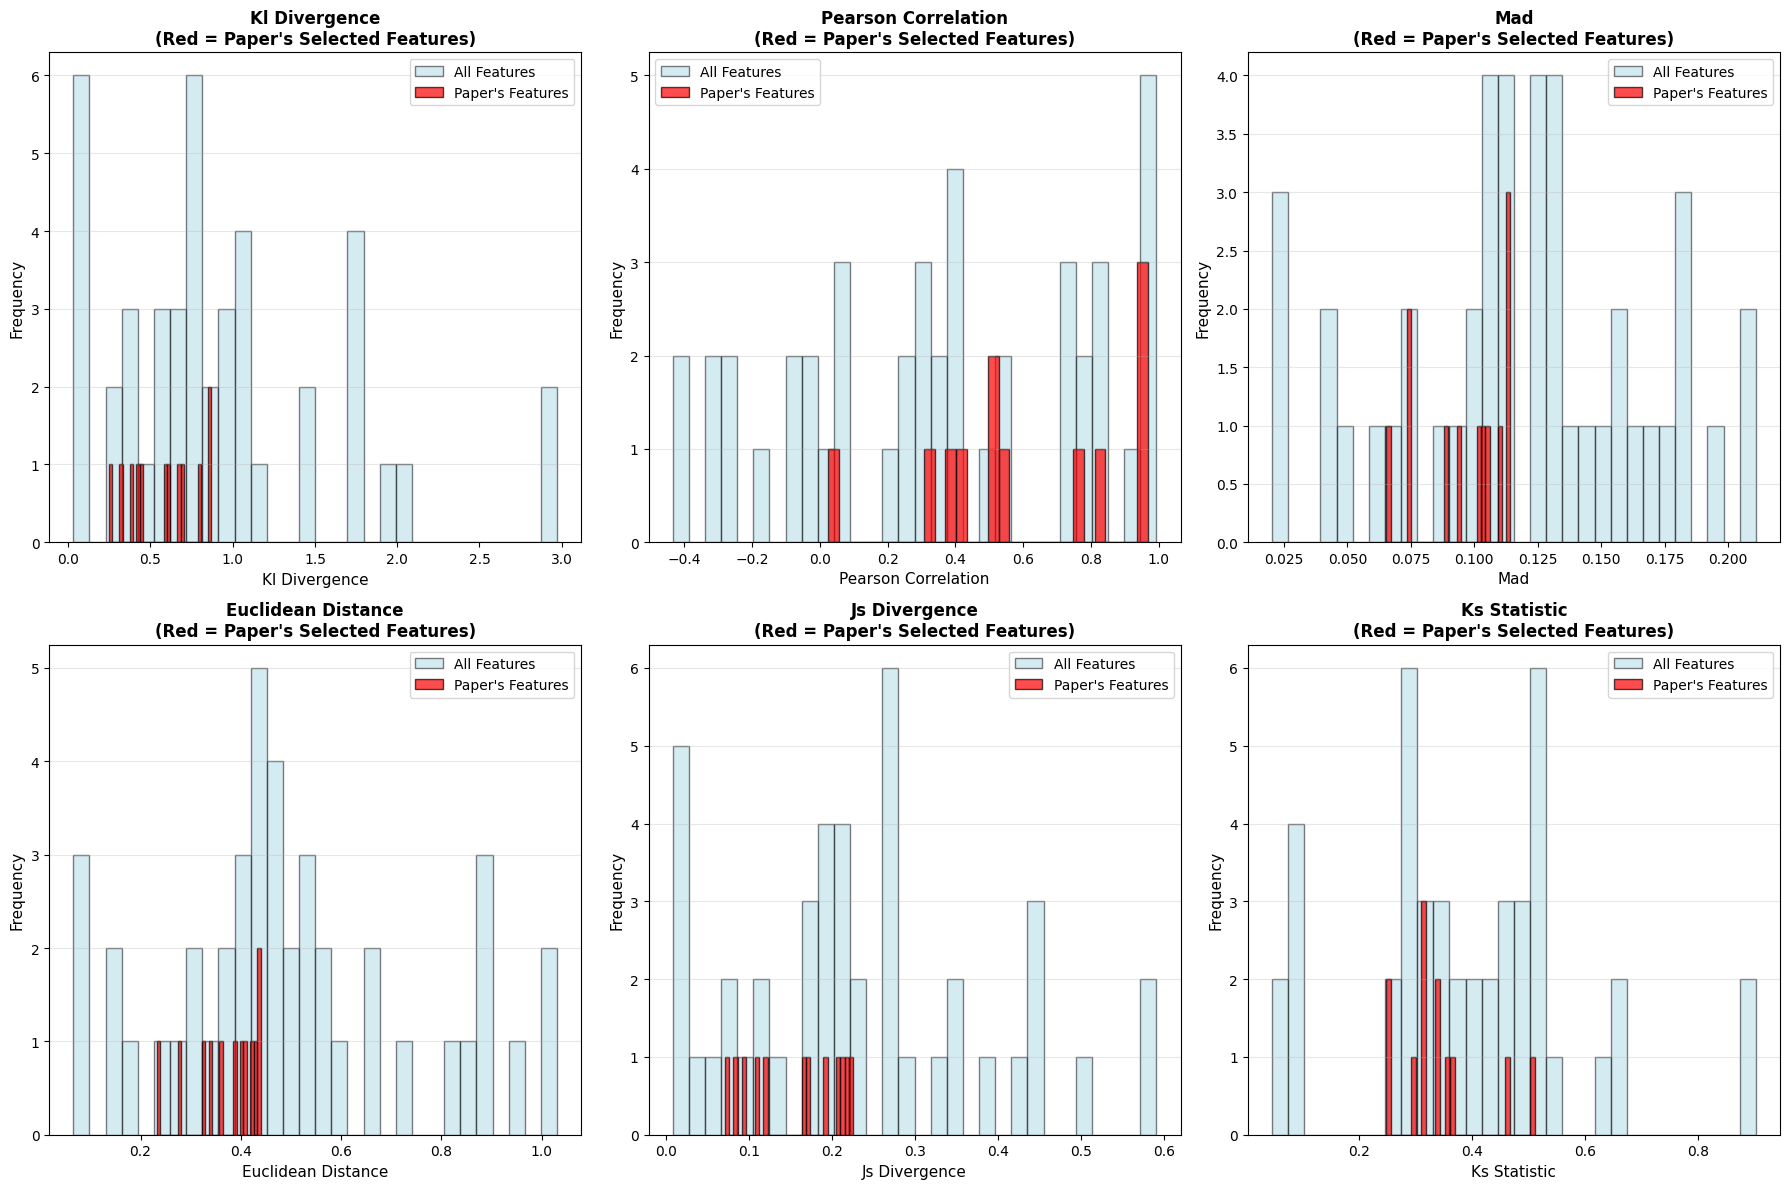

In [31]:
# Visualize metric distributions with paper's features highlighted
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

metrics_plot = ['kl_divergence', 'pearson_correlation', 'mad', 
                'euclidean_distance', 'js_divergence', 'ks_statistic']

# Get all unique features from paper
all_paper_features = set()
for features in paper_features_all.values():
    all_paper_features.update(features)

for idx, metric in enumerate(metrics_plot):
    ax = axes[idx]
    
    # Plot histogram for all features
    ax.hist(results_df[metric], bins=30, alpha=0.5, label='All Features', 
            edgecolor='black', color='lightblue')
    
    # Highlight paper's features
    paper_values = []
    for feature in all_paper_features:
        if feature in results_df['feature'].values:
            val = results_df[results_df['feature'] == feature][metric].values[0]
            paper_values.append(val)
    
    if paper_values:
        ax.hist(paper_values, bins=30, alpha=0.7, label="Paper's Features", 
                edgecolor='black', color='red')
    
    ax.set_xlabel(metric.replace('_', ' ').title(), fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title(f'{metric.replace("_", " ").title()}\n(Red = Paper\'s Selected Features)', 
                 fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/huyong97/personal/benford_law/playgrounds/metrics_comparison_with_paper.png', 
            dpi=300, bbox_inches='tight')
plt.show()

In [32]:
# Determine optimal thresholds based on paper's selected features
print("\n" + "="*80)
print("DETERMINING OPTIMAL THRESHOLDS FROM PAPER'S FEATURES")
print("="*80)

# For each method, look at the range of values in paper's selected features
optimal_thresholds = {}

for method, features in paper_features_all.items():
    print(f"\n{method} Method:")
    
    # Get metric values for paper's features
    available_features = [f for f in features if f in results_df['feature'].values]
    
    if not available_features:
        print(f"  Warning: None of paper's features found in results!")
        continue
    
    paper_subset = results_df[results_df['feature'].isin(available_features)]
    
    if method == 'KL':
        metric_col = 'kl_divergence'
        max_val = paper_subset[metric_col].max()
        print(f"  KL Divergence range: {paper_subset[metric_col].min():.6f} - {max_val:.6f}")
        optimal_thresholds['kl_divergence'] = max_val * 1.1  # 10% buffer
        
    elif method == 'Pearson':
        metric_col = 'pearson_correlation'
        min_val = paper_subset[metric_col].min()
        print(f"  Pearson Correlation range: {min_val:.6f} - {paper_subset[metric_col].max():.6f}")
        optimal_thresholds['pearson_correlation'] = min_val * 0.9  # 10% buffer
        
    elif method == 'MAD':
        metric_col = 'mad'
        max_val = paper_subset[metric_col].max()
        print(f"  MAD range: {paper_subset[metric_col].min():.6e} - {max_val:.6e}")
        optimal_thresholds['mad'] = max_val * 1.1  # 10% buffer
        
    elif method == 'Euclidean':
        metric_col = 'euclidean_distance'
        max_val = paper_subset[metric_col].max()
        print(f"  Euclidean Distance range: {paper_subset[metric_col].min():.6f} - {max_val:.6f}")
        optimal_thresholds['euclidean_distance'] = max_val * 1.1  # 10% buffer

print(f"\nOptimal Thresholds:")
print(f"  KL Divergence:       ≤ {optimal_thresholds.get('kl_divergence', 'N/A'):.6f}")
print(f"  Pearson Correlation: ≥ {optimal_thresholds.get('pearson_correlation', 'N/A'):.6f}")
print(f"  MAD:                 ≤ {optimal_thresholds.get('mad', 'N/A'):.6e}")
print(f"  Euclidean Distance:  ≤ {optimal_thresholds.get('euclidean_distance', 'N/A'):.6f}")


DETERMINING OPTIMAL THRESHOLDS FROM PAPER'S FEATURES

KL Method:
  KL Divergence range: 0.248709 - 0.438991

Pearson Method:
  Pearson Correlation range: 0.024006 - 0.968271

MAD Method:
  MAD range: 8.834656e-02 - 1.141307e-01

Euclidean Method:
  Euclidean Distance range: 0.232694 - 0.401928

Optimal Thresholds:
  KL Divergence:       ≤ 0.482890
  Pearson Correlation: ≥ 0.021605
  MAD:                 ≤ 1.255438e-01
  Euclidean Distance:  ≤ 0.442120


In [33]:
# Re-run feature selection with optimal thresholds
print("\n" + "="*80)
print("RE-RUNNING FEATURE SELECTION WITH OPTIMAL THRESHOLDS")
print("="*80)

selected_features_optimal = {}

# 1. KL Selection with optimal threshold
if 'kl_divergence' in optimal_thresholds:
    kl_threshold = optimal_thresholds['kl_divergence']
    kl_selected_optimal = results_df[results_df['kl_divergence'] <= kl_threshold]['feature'].tolist()
    selected_features_optimal['KL'] = kl_selected_optimal
    print(f"\n1. KL Divergence (≤ {kl_threshold:.6f}):")
    print(f"   Selected features: {len(kl_selected_optimal)}")
    print(f"   Features: {kl_selected_optimal}")

# 2. Pearson Selection with optimal threshold
if 'pearson_correlation' in optimal_thresholds:
    pearson_threshold = optimal_thresholds['pearson_correlation']
    pearson_selected_optimal = results_df[results_df['pearson_correlation'] >= pearson_threshold]['feature'].tolist()
    selected_features_optimal['Pearson'] = pearson_selected_optimal
    print(f"\n2. Pearson Correlation (≥ {pearson_threshold:.6f}):")
    print(f"   Selected features: {len(pearson_selected_optimal)}")
    print(f"   Features: {pearson_selected_optimal}")

# 3. MAD Selection with optimal threshold
if 'mad' in optimal_thresholds:
    mad_threshold = optimal_thresholds['mad']
    mad_selected_optimal = results_df[results_df['mad'] <= mad_threshold]['feature'].tolist()
    selected_features_optimal['MAD'] = mad_selected_optimal
    print(f"\n3. MAD (≤ {mad_threshold:.6e}):")
    print(f"   Selected features: {len(mad_selected_optimal)}")
    print(f"   Features: {mad_selected_optimal}")

# 4. Euclidean Selection with optimal threshold
if 'euclidean_distance' in optimal_thresholds:
    euclidean_threshold = optimal_thresholds['euclidean_distance']
    euclidean_selected_optimal = results_df[results_df['euclidean_distance'] <= euclidean_threshold]['feature'].tolist()
    selected_features_optimal['Euclidean'] = euclidean_selected_optimal
    print(f"\n4. Euclidean Distance (≤ {euclidean_threshold:.6f}):")
    print(f"   Selected features: {len(euclidean_selected_optimal)}")
    print(f"   Features: {euclidean_selected_optimal}")


RE-RUNNING FEATURE SELECTION WITH OPTIMAL THRESHOLDS

1. KL Divergence (≤ 0.482890):
   Selected features: 12
   Features: ['handles.nsection', 'malfind.commitCharge', 'malfind.protection', 'psxview.not_in_pslist', 'psxview.not_in_ethread_pool', 'psxview.not_in_pspcid_list', 'psxview.not_in_session', 'psxview.not_in_pslist_false_avg', 'psxview.not_in_eprocess_pool_false_avg', 'psxview.not_in_ethread_pool_false_avg', 'psxview.not_in_pspcid_list_false_avg', 'psxview.not_in_session_false_avg']

2. Pearson Correlation (≥ 0.021605):
   Selected features: 33
   Features: ['pslist.avg_threads', 'pslist.avg_handlers', 'dlllist.ndlls', 'handles.nhandles', 'handles.avg_handles_per_proc', 'handles.nfile', 'handles.nevent', 'handles.nthread', 'handles.ndirectory', 'handles.nsection', 'handles.nmutant', 'ldrmodules.not_in_init', 'ldrmodules.not_in_load_avg', 'ldrmodules.not_in_mem_avg', 'malfind.ninjections', 'malfind.commitCharge', 'malfind.protection', 'psxview.not_in_pslist', 'psxview.not_in_et

In [34]:
# Compare with paper again using optimal thresholds
print("\n" + "="*80)
print("COMPARISON WITH PAPER USING OPTIMAL THRESHOLDS")
print("="*80)

for method in ['KL', 'Pearson', 'MAD', 'Euclidean']:
    if method not in selected_features_optimal:
        continue
        
    print(f"\n{method} Method:")
    print(f"  Paper's selected: {len(paper_features_all[method])}")
    print(f"  Our selection: {len(selected_features_optimal[method])}")
    
    # Find overlap
    overlap = set(paper_features_all[method]) & set(selected_features_optimal[method])
    print(f"  Overlap: {len(overlap)} features ({len(overlap)/len(paper_features_all[method])*100:.1f}%)")
    
    if overlap:
        print(f"  Common features: {list(overlap)}")
    
    # Show missing features
    missing = set(paper_features_all[method]) - set(selected_features_optimal[method])
    if missing:
        print(f"  Missing from paper: {list(missing)}")


COMPARISON WITH PAPER USING OPTIMAL THRESHOLDS

KL Method:
  Paper's selected: 5
  Our selection: 12
  Overlap: 5 features (100.0%)
  Common features: ['handles.nsection', 'malfind.protection', 'psxview.not_in_session_false_avg', 'malfind.commitCharge', 'psxview.not_in_session']

Pearson Method:
  Paper's selected: 7
  Our selection: 33
  Overlap: 4 features (57.1%)
  Common features: ['malfind.protection', 'psxview.not_in_session_false_avg', 'dlllist.ndlls', 'malfind.commitCharge']
  Missing from paper: ['handles.ntimer', 'malfind.uniqueInjections', 'pslist.nppid']

MAD Method:
  Paper's selected: 7
  Our selection: 26
  Overlap: 6 features (85.7%)
  Common features: ['handles.nsection', 'handles.nhandles', 'handles.nthread', 'psxview.not_in_deskthrd_false_avg', 'ldrmodules.not_in_init', 'handles.nfile']
  Missing from paper: ['handles.ntimer']

Euclidean Method:
  Paper's selected: 7
  Our selection: 21
  Overlap: 7 features (100.0%)
  Common features: ['handles.nsection', 'psxview.

In [35]:
# Create a detailed comparison table
print("\n" + "="*80)
print("DETAILED FEATURE COMPARISON TABLE")
print("="*80)

# Create comparison dataframe
comparison_data = []

all_features_to_check = set()
for features in paper_features_all.values():
    all_features_to_check.update(features)

for feature in sorted(all_features_to_check):
    if feature not in results_df['feature'].values:
        comparison_data.append({
            'feature': feature,
            'in_results': False,
            'paper_KL': 'X' if feature in paper_features_all['KL'] else '',
            'paper_Pearson': 'X' if feature in paper_features_all['Pearson'] else '',
            'paper_MAD': 'X' if feature in paper_features_all['MAD'] else '',
            'paper_Euclidean': 'X' if feature in paper_features_all['Euclidean'] else '',
            'our_KL': '',
            'our_Pearson': '',
            'our_MAD': '',
            'our_Euclidean': ''
        })
    else:
        comparison_data.append({
            'feature': feature,
            'in_results': True,
            'paper_KL': 'X' if feature in paper_features_all['KL'] else '',
            'paper_Pearson': 'X' if feature in paper_features_all['Pearson'] else '',
            'paper_MAD': 'X' if feature in paper_features_all['MAD'] else '',
            'paper_Euclidean': 'X' if feature in paper_features_all['Euclidean'] else '',
            'our_KL': 'X' if 'KL' in selected_features_optimal and feature in selected_features_optimal['KL'] else '',
            'our_Pearson': 'X' if 'Pearson' in selected_features_optimal and feature in selected_features_optimal['Pearson'] else '',
            'our_MAD': 'X' if 'MAD' in selected_features_optimal and feature in selected_features_optimal['MAD'] else '',
            'our_Euclidean': 'X' if 'Euclidean' in selected_features_optimal and feature in selected_features_optimal['Euclidean'] else ''
        })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Save comparison
comparison_path = '/Users/huyong97/personal/benford_law/playgrounds/paper_comparison.csv'
comparison_df.to_csv(comparison_path, index=False)
print(f"\nComparison saved to: {comparison_path}")


DETAILED FEATURE COMPARISON TABLE
                               feature  in_results paper_KL paper_Pearson paper_MAD paper_Euclidean our_KL our_Pearson our_MAD our_Euclidean
                         dlllist.ndlls        True                      X                                            X       X             X
                         handles.nfile        True                                X                                  X       X             X
                      handles.nhandles        True                                X                                  X       X             X
                      handles.nsection        True        X                       X               X      X           X       X             X
                       handles.nthread        True                                X               X                  X       X             X
                        handles.ntimer       False                      X         X                                    

In [36]:
# Show statistics summary
print("\n" + "="*80)
print("SELECTION STATISTICS SUMMARY")
print("="*80)

summary_data = []
for method in ['KL', 'Pearson', 'MAD', 'Euclidean']:
    paper_count = len(paper_features_all[method])
    our_count = len(selected_features_optimal.get(method, []))
    overlap_count = len(set(paper_features_all[method]) & set(selected_features_optimal.get(method, [])))
    
    summary_data.append({
        'Method': method,
        'Paper Selected': paper_count,
        'Our Selection': our_count,
        'Overlap': overlap_count,
        'Overlap %': f"{overlap_count/paper_count*100:.1f}%"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))


SELECTION STATISTICS SUMMARY
   Method  Paper Selected  Our Selection  Overlap Overlap %
       KL               5             12        5    100.0%
  Pearson               7             33        4     57.1%
      MAD               7             26        6     85.7%
Euclidean               7             21        7    100.0%


In [38]:
# Export all selected features with optimal thresholds
print("\n" + "="*80)
print("EXPORTING SELECTED FEATURES")
print("="*80)

for method, features in selected_features_optimal.items():
    output_file = f'/Users/huyong97/personal/benford_law/playgrounds/selected_features_{method.lower()}_optimal.txt'
    with open(output_file, 'w') as f:
        f.write(f"Selected features using {method} method (Optimal Thresholds)\n")
        f.write(f"Total: {len(features)}\n")
        if method == 'KL':
            f.write(f"Threshold: KL Divergence ≤ {optimal_thresholds.get('kl_divergence', 'N/A'):.6f}\n\n")
        elif method == 'Pearson':
            f.write(f"Threshold: Pearson Correlation ≥ {optimal_thresholds.get('pearson_correlation', 'N/A'):.6f}\n\n")
        elif method == 'MAD':
            f.write(f"Threshold: MAD ≤ {optimal_thresholds.get('mad', 'N/A'):.6e}\n\n")
        elif method == 'Euclidean':
            f.write(f"Threshold: Euclidean Distance ≤ {optimal_thresholds.get('euclidean_distance', 'N/A'):.6f}\n\n")
        
        for feature in features:
            f.write(f"{feature}\n")
    
    print(f"Saved {method} selected features to: {output_file}")

# Save updated results with optimal thresholds
results_optimal_path = '/Users/huyong97/personal/benford_law/playgrounds/feature_selection_results_optimal.csv'
results_df.to_csv(results_optimal_path, index=False)
print(f"\nOptimal results saved to: {results_optimal_path}")


EXPORTING SELECTED FEATURES
Saved KL selected features to: /Users/huyong97/personal/benford_law/playgrounds/selected_features_kl_optimal.txt
Saved Pearson selected features to: /Users/huyong97/personal/benford_law/playgrounds/selected_features_pearson_optimal.txt
Saved MAD selected features to: /Users/huyong97/personal/benford_law/playgrounds/selected_features_mad_optimal.txt
Saved Euclidean selected features to: /Users/huyong97/personal/benford_law/playgrounds/selected_features_euclidean_optimal.txt

Optimal results saved to: /Users/huyong97/personal/benford_law/playgrounds/feature_selection_results_optimal.csv


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from scipy import stats

# Load preprocessed data
preprocessed_path = '/Users/huyong97/personal/benford_law/playgrounds/preprocessed_MalMem2022.csv'
df = pd.read_csv(preprocessed_path)

# Load feature selection results
results_path = '/Users/huyong97/personal/benford_law/playgrounds/feature_selection_results_optimal.csv'
feature_results = pd.read_csv(results_path)

print("="*80)
print("MODEL EVALUATION USING SELECTED FEATURES")
print("="*80)
print(f"Total flows: {len(df)}")
print(f"Benign flows: {(df['Class'] == 'Benign').sum()}")
print(f"Malicious flows: {(df['Class'] != 'Benign').sum()}")

MODEL EVALUATION USING SELECTED FEATURES
Total flows: 58596
Benign flows: 29298
Malicious flows: 29298


In [40]:
# Load selected features for each method
selected_features_optimal = {
    'KL': feature_results[feature_results['kl_divergence'] <= 0.482890]['feature'].tolist(),
    'Pearson': feature_results[feature_results['pearson_correlation'] >= 0.021605]['feature'].tolist(),
    'MAD': feature_results[feature_results['mad'] <= 1.255438e-01]['feature'].tolist(),
    'Euclidean': feature_results[feature_results['euclidean_distance'] <= 0.442120]['feature'].tolist()
}

print("\nSelected features per method:")
for method, features in selected_features_optimal.items():
    print(f"  {method}: {len(features)} features")


Selected features per method:
  KL: 12 features
  Pearson: 33 features
  MAD: 26 features
  Euclidean: 21 features


In [41]:
# Benford's Law expected frequencies
benford_freq = np.array([np.log10(1 + 1/d) for d in range(1, 10)])

def calculate_flow_frequencies(row, feature_cols):
    """
    Calculate digit frequencies for a single flow using selected features
    """
    digits = row[feature_cols].values
    non_zero = digits[digits > 0]
    
    if len(non_zero) == 0:
        return np.zeros(9)
    
    frequencies = np.zeros(9)
    for i, digit in enumerate(range(1, 10)):
        frequencies[i] = (non_zero == digit).sum() / len(non_zero)
    
    return frequencies

def classify_using_distance_function(df, selected_features, evaluation_metric, 
                                     significance_level=None, threshold=None):
    """
    Classify flows as benign (0) or malicious (1) using distance functions
    
    Parameters:
    - df: DataFrame with preprocessed data
    - selected_features: List of features to use
    - evaluation_metric: 'kl', 'pearson', 'mad', 'js', 'z', 'ks'
    - significance_level: For statistical tests (0.05, 0.01, 0.1)
    - threshold: Custom threshold for divergence measures
    """
    feature_cols = [f'{feat}_first_digit' for feat in selected_features]
    predictions = []
    
    for idx, row in df.iterrows():
        # Calculate observed frequencies for this flow
        observed_freq = calculate_flow_frequencies(row, feature_cols)
        
        # Calculate distance metric
        if evaluation_metric == 'kl':
            # KL divergence
            epsilon = 1e-10
            obs = observed_freq + epsilon
            exp = benford_freq + epsilon
            obs = obs / obs.sum()
            exp = exp / exp.sum()
            metric_value = np.sum(obs * np.log(obs / exp))
            
            # Higher divergence = malicious
            threshold = threshold if threshold is not None else 0.20
            prediction = 1 if metric_value >= threshold else 0
            
        elif evaluation_metric == 'pearson':
            # Pearson correlation
            if observed_freq.sum() == 0:
                prediction = 1  # Consider as malicious if no data
            else:
                corr, p_value = stats.pearsonr(observed_freq, benford_freq)
                
                # Use p-value for significance testing
                sig_level = significance_level if significance_level is not None else 0.05
                prediction = 1 if p_value < sig_level else 0
                
        elif evaluation_metric == 'mad':
            # Mean Absolute Deviation
            mad_value = np.mean(np.abs(observed_freq - benford_freq))
            
            threshold = threshold if threshold is not None else 0.06
            prediction = 1 if mad_value > threshold else 0
            
        elif evaluation_metric == 'js':
            # Jensen-Shannon divergence
            epsilon = 1e-10
            P = observed_freq + epsilon
            Q = benford_freq + epsilon
            P = P / P.sum()
            Q = Q / Q.sum()
            M = 0.5 * (P + Q)
            js_value = 0.5 * np.sum(P * np.log(P / M)) + 0.5 * np.sum(Q * np.log(Q / M))
            
            threshold = threshold if threshold is not None else 0.15
            prediction = 1 if js_value >= threshold else 0
            
        elif evaluation_metric == 'z':
            # Z-statistic
            n_obs = len(observed_freq[observed_freq > 0])
            if n_obs == 0:
                prediction = 1
            else:
                z_values = []
                for ap, fe in zip(observed_freq, benford_freq):
                    if fe == 0 or fe == 1:
                        continue
                    numerator = abs(ap - fe) - (1 / (2 * n_obs))
                    denominator = np.sqrt((fe * (1 - fe)) / n_obs)
                    if denominator > 0:
                        z_values.append(abs(numerator / denominator))
                
                z_stat = np.sum(z_values) if z_values else 0
                
                # Use threshold or percentile
                threshold = threshold if threshold is not None else 5.0
                prediction = 1 if z_stat >= threshold else 0
                
        elif evaluation_metric == 'ks':
            # Kolmogorov-Smirnov statistic
            observed_cumsum = np.cumsum(observed_freq)
            expected_cumsum = np.cumsum(benford_freq)
            ks_stat = np.max(np.abs(observed_cumsum - expected_cumsum))
            
            sig_level = significance_level if significance_level is not None else 0.05
            # KS critical value approximation
            n = len(observed_freq[observed_freq > 0])
            if n > 0:
                critical_value = 1.36 / np.sqrt(n) if sig_level == 0.05 else 1.63 / np.sqrt(n)
                prediction = 1 if ks_stat >= critical_value else 0
            else:
                prediction = 1
        
        predictions.append(prediction)
    
    return np.array(predictions)

In [42]:
# Evaluation configurations from the paper (Table 11-14)
evaluation_configs = [
    # KL-based feature selection
    {'selection': 'KL', 'evaluation': 'kl', 'params': {'threshold': 0.20}},
    {'selection': 'KL', 'evaluation': 'pearson', 'params': {'significance_level': 0.05}},
    {'selection': 'KL', 'evaluation': 'pearson', 'params': {'significance_level': 0.1}},
    {'selection': 'KL', 'evaluation': 'pearson', 'params': {'significance_level': 0.01}},
    {'selection': 'KL', 'evaluation': 'mad', 'params': {'threshold': 0.06}},
    {'selection': 'KL', 'evaluation': 'ks', 'params': {'significance_level': 0.05}},
    {'selection': 'KL', 'evaluation': 'ks', 'params': {'significance_level': 0.1}},
    {'selection': 'KL', 'evaluation': 'z', 'params': {'threshold': 5.0}},
    {'selection': 'KL', 'evaluation': 'js', 'params': {'threshold': 0.15}},
    
    # Pearson-based feature selection
    {'selection': 'Pearson', 'evaluation': 'pearson', 'params': {'significance_level': 0.05}},
    {'selection': 'Pearson', 'evaluation': 'pearson', 'params': {'significance_level': 0.1}},
    {'selection': 'Pearson', 'evaluation': 'pearson', 'params': {'significance_level': 0.01}},
    {'selection': 'Pearson', 'evaluation': 'mad', 'params': {}},
    {'selection': 'Pearson', 'evaluation': 'ks', 'params': {'significance_level': 0.01}},
    {'selection': 'Pearson', 'evaluation': 'kl', 'params': {}},
    {'selection': 'Pearson', 'evaluation': 'z', 'params': {}},
    {'selection': 'Pearson', 'evaluation': 'js', 'params': {}},
    
    # MAD-based feature selection
    {'selection': 'MAD', 'evaluation': 'mad', 'params': {}},
    {'selection': 'MAD', 'evaluation': 'pearson', 'params': {'significance_level': 0.05}},
    {'selection': 'MAD', 'evaluation': 'kl', 'params': {}},
    {'selection': 'MAD', 'evaluation': 'z', 'params': {}},
    
    # Euclidean-based feature selection
    {'selection': 'Euclidean', 'evaluation': 'kl', 'params': {}},
    {'selection': 'Euclidean', 'evaluation': 'z', 'params': {}},
    {'selection': 'Euclidean', 'evaluation': 'js', 'params': {}},
]

print("\nEvaluating model with different configurations...")
print("This may take a few minutes...\n")


Evaluating model with different configurations...
This may take a few minutes...



In [43]:
# Run evaluations
evaluation_results = []

for config in evaluation_configs:
    selection_method = config['selection']
    eval_metric = config['evaluation']
    params = config['params']
    
    # Get selected features
    features = selected_features_optimal[selection_method]
    
    if len(features) == 0:
        print(f"Skipping {selection_method} + {eval_metric}: No features selected")
        continue
    
    print(f"Evaluating: {selection_method} selection + {eval_metric} evaluation")
    
    # Make predictions
    predictions = classify_using_distance_function(df, features, eval_metric, **params)
    
    # Get true labels (1 = Malicious, 0 = Benign)
    y_true = (df['Class'] != 'Benign').astype(int).values
    
    # Calculate metrics
    tn, fp, fn, tp = confusion_matrix(y_true, predictions).ravel()
    
    precision = precision_score(y_true, predictions, zero_division=0)
    recall = recall_score(y_true, predictions, zero_division=0)
    f1 = f1_score(y_true, predictions, zero_division=0)
    accuracy = accuracy_score(y_true, predictions)
    
    # Store results
    result = {
        'selection_method': selection_method,
        'evaluation_metric': eval_metric,
        'params': str(params),
        'n_features': len(features),
        'TP': tp,
        'FN': fn,
        'FP': fp,
        'TN': tn,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'Accuracy': accuracy
    }
    
    evaluation_results.append(result)
    
    print(f"  Features: {len(features)} | F1: {f1:.4f} | Accuracy: {accuracy:.4f}")

results_eval_df = pd.DataFrame(evaluation_results)
print("\nEvaluation complete!")

Evaluating: KL selection + kl evaluation
  Features: 12 | F1: 0.6666 | Accuracy: 0.5006
Evaluating: KL selection + pearson evaluation
  Features: 12 | F1: 0.6306 | Accuracy: 0.6599
Evaluating: KL selection + pearson evaluation
  Features: 12 | F1: 0.6291 | Accuracy: 0.6429
Evaluating: KL selection + pearson evaluation
  Features: 12 | F1: 0.5138 | Accuracy: 0.6109
Evaluating: KL selection + mad evaluation
  Features: 12 | F1: 0.6703 | Accuracy: 0.5248
Evaluating: KL selection + ks evaluation
  Features: 12 | F1: 0.0000 | Accuracy: 0.4999
Evaluating: KL selection + ks evaluation
  Features: 12 | F1: 0.0000 | Accuracy: 0.5000
Evaluating: KL selection + z evaluation
  Features: 12 | F1: 0.1801 | Accuracy: 0.3412
Evaluating: KL selection + js evaluation
  Features: 12 | F1: 0.4390 | Accuracy: 0.3942
Evaluating: Pearson selection + pearson evaluation
  Features: 33 | F1: 0.5180 | Accuracy: 0.3553
Evaluating: Pearson selection + pearson evaluation
  Features: 33 | F1: 0.6255 | Accuracy: 0.45

In [44]:
# Display top results
print("\n" + "="*80)
print("TOP 10 CONFIGURATIONS BY F1-SCORE")
print("="*80)

top_10 = results_eval_df.nlargest(10, 'F1_Score')
print(top_10[['selection_method', 'evaluation_metric', 'F1_Score', 'Precision', 
              'Recall', 'Accuracy', 'n_features']].to_string(index=False))


TOP 10 CONFIGURATIONS BY F1-SCORE
selection_method evaluation_metric  F1_Score  Precision   Recall  Accuracy  n_features
              KL               mad  0.670251   0.513174 0.965902  0.524797          12
              KL                kl  0.666606   0.500282 0.998601  0.500563          12
       Euclidean                kl  0.663945   0.537291 0.868728  0.560294          21
         Pearson                kl  0.654389   0.607221 0.709502  0.625282          33
              KL           pearson  0.630556   0.690036 0.580517  0.659874          12
              KL           pearson  0.629082   0.654493 0.605570  0.642945          12
         Pearson           pearson  0.625510   0.477183 0.907639  0.456601          33
         Pearson               mad  0.557137   0.865516 0.410779  0.673476          33
         Pearson           pearson  0.518035   0.413639 0.692914  0.355331          33
              KL           pearson  0.513830   0.684761 0.411188  0.610946          12


In [45]:
# Compare with paper's best results (Table 11)
print("\n" + "="*80)
print("COMPARISON WITH PAPER'S BEST RESULT (Table 11)")
print("="*80)
print("Paper's Best: KL + Pearson (0.1)")
print("  Precision: 88.30% | Recall: 82.08% | F1: 85.08% | Accuracy: 85.60%")

# Find our equivalent configuration
our_best_kl_pearson = results_eval_df[
    (results_eval_df['selection_method'] == 'KL') & 
    (results_eval_df['evaluation_metric'] == 'pearson') &
    (results_eval_df['params'].str.contains('0.1'))
]

if len(our_best_kl_pearson) > 0:
    our_result = our_best_kl_pearson.iloc[0]
    print(f"\nOur Result: KL + Pearson (0.1)")
    print(f"  Precision: {our_result['Precision']*100:.2f}% | Recall: {our_result['Recall']*100:.2f}% | "
          f"F1: {our_result['F1_Score']*100:.2f}% | Accuracy: {our_result['Accuracy']*100:.2f}%")
    print(f"  TP: {our_result['TP']} | FN: {our_result['FN']} | FP: {our_result['FP']} | TN: {our_result['TN']}")


COMPARISON WITH PAPER'S BEST RESULT (Table 11)
Paper's Best: KL + Pearson (0.1)
  Precision: 88.30% | Recall: 82.08% | F1: 85.08% | Accuracy: 85.60%

Our Result: KL + Pearson (0.1)
  Precision: 65.45% | Recall: 60.56% | F1: 62.91% | Accuracy: 64.29%
  TP: 17742 | FN: 11556 | FP: 9366 | TN: 19932



BEST CONFIGURATION: KL + mad
F1-Score: 0.6703
Precision: 0.5132
Recall: 0.9659
Accuracy: 0.5248
Features used: 12


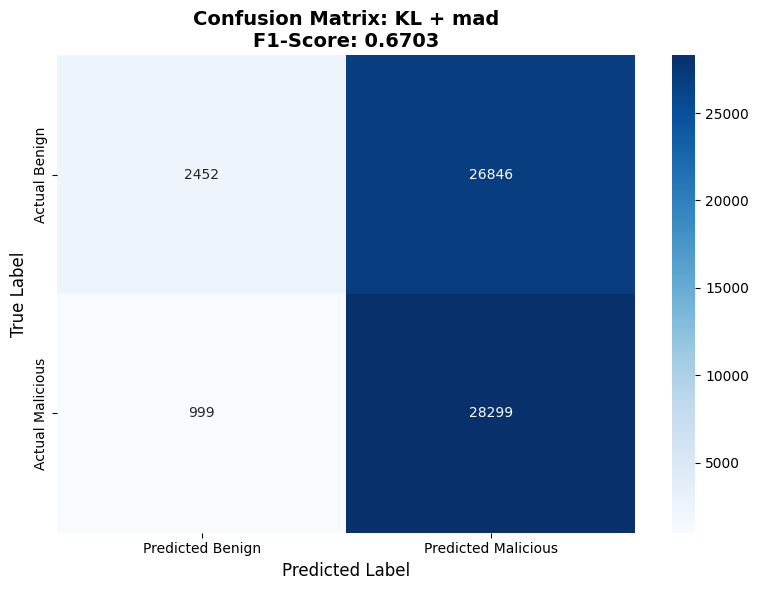

In [46]:
# Visualize confusion matrix for best result
best_result = results_eval_df.nlargest(1, 'F1_Score').iloc[0]

print(f"\n" + "="*80)
print(f"BEST CONFIGURATION: {best_result['selection_method']} + {best_result['evaluation_metric']}")
print("="*80)
print(f"F1-Score: {best_result['F1_Score']:.4f}")
print(f"Precision: {best_result['Precision']:.4f}")
print(f"Recall: {best_result['Recall']:.4f}")
print(f"Accuracy: {best_result['Accuracy']:.4f}")
print(f"Features used: {best_result['n_features']}")

# Create confusion matrix
cm = np.array([[best_result['TN'], best_result['FP']], 
               [best_result['FN'], best_result['TP']]])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Predicted Benign', 'Predicted Malicious'],
            yticklabels=['Actual Benign', 'Actual Malicious'])
plt.title(f'Confusion Matrix: {best_result["selection_method"]} + {best_result["evaluation_metric"]}\n'
          f'F1-Score: {best_result["F1_Score"]:.4f}', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('/Users/huyong97/personal/benford_law/playgrounds/best_confusion_matrix.png', 
            dpi=300, bbox_inches='tight')
plt.show()

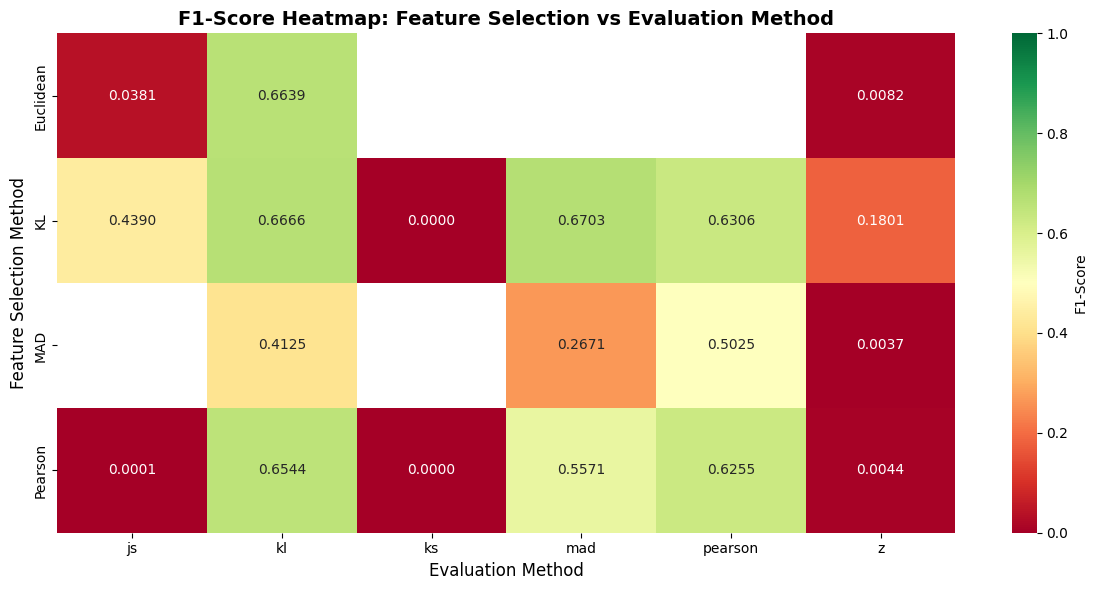


F1-Score Summary (Max per combination):
evaluation_metric        js        kl   ks       mad   pearson         z
selection_method                                                        
Euclidean          0.038145  0.663945  NaN       NaN       NaN  0.008208
KL                 0.439004  0.666606  0.0  0.670251  0.630556  0.180146
MAD                     NaN  0.412502  NaN  0.267148  0.502452  0.003673
Pearson            0.000068  0.654389  0.0  0.557137  0.625510  0.004427


In [47]:
# Compare F1-scores across different combinations
pivot_f1 = results_eval_df.pivot_table(
    values='F1_Score', 
    index='selection_method', 
    columns='evaluation_metric', 
    aggfunc='max'
)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_f1, annot=True, fmt='.4f', cmap='RdYlGn', 
            vmin=0, vmax=1, cbar_kws={'label': 'F1-Score'})
plt.title('F1-Score Heatmap: Feature Selection vs Evaluation Method', 
          fontsize=14, fontweight='bold')
plt.xlabel('Evaluation Method', fontsize=12)
plt.ylabel('Feature Selection Method', fontsize=12)
plt.tight_layout()
plt.savefig('/Users/huyong97/personal/benford_law/playgrounds/f1_score_heatmap.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\nF1-Score Summary (Max per combination):")
print(pivot_f1)

In [48]:
# Save all evaluation results
output_path = '/Users/huyong97/personal/benford_law/playgrounds/evaluation_results.csv'
results_eval_df.to_csv(output_path, index=False)
print(f"\nAll evaluation results saved to: {output_path}")

# Generate classification report for best configuration
print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORT (Best Configuration)")
print("="*80)

# Re-run best configuration to get predictions
best_features = selected_features_optimal[best_result['selection_method']]
best_eval = best_result['evaluation_metric']
best_params_str = best_result['params']

# Parse params
import ast
best_params = ast.literal_eval(best_params_str) if best_params_str != '{}' else {}

predictions = classify_using_distance_function(df, best_features, best_eval, **best_params)
y_true = (df['Class'] != 'Benign').astype(int).values

print(classification_report(y_true, predictions, 
                          target_names=['Benign', 'Malicious'], 
                          digits=4))


All evaluation results saved to: /Users/huyong97/personal/benford_law/playgrounds/evaluation_results.csv

DETAILED CLASSIFICATION REPORT (Best Configuration)
              precision    recall  f1-score   support

      Benign     0.7105    0.0837    0.1497     29298
   Malicious     0.5132    0.9659    0.6703     29298

    accuracy                         0.5248     58596
   macro avg     0.6118    0.5248    0.4100     58596
weighted avg     0.6118    0.5248    0.4100     58596



In [49]:
# Summary statistics
print("\n" + "="*80)
print("EVALUATION SUMMARY")
print("="*80)

print(f"\nTotal configurations tested: {len(results_eval_df)}")
print(f"Average F1-Score: {results_eval_df['F1_Score'].mean():.4f}")
print(f"Best F1-Score: {results_eval_df['F1_Score'].max():.4f}")
print(f"Worst F1-Score: {results_eval_df['F1_Score'].min():.4f}")

print("\nBest configuration per selection method:")
for method in ['KL', 'Pearson', 'MAD', 'Euclidean']:
    method_results = results_eval_df[results_eval_df['selection_method'] == method]
    if len(method_results) > 0:
        best = method_results.nlargest(1, 'F1_Score').iloc[0]
        print(f"\n{method}:")
        print(f"  Best evaluation: {best['evaluation_metric']}")
        print(f"  F1-Score: {best['F1_Score']:.4f}")
        print(f"  Precision: {best['Precision']:.4f}")
        print(f"  Recall: {best['Recall']:.4f}")
        print(f"  Accuracy: {best['Accuracy']:.4f}")


EVALUATION SUMMARY

Total configurations tested: 24
Average F1-Score: 0.3423
Best F1-Score: 0.6703
Worst F1-Score: 0.0000

Best configuration per selection method:

KL:
  Best evaluation: mad
  F1-Score: 0.6703
  Precision: 0.5132
  Recall: 0.9659
  Accuracy: 0.5248

Pearson:
  Best evaluation: kl
  F1-Score: 0.6544
  Precision: 0.6072
  Recall: 0.7095
  Accuracy: 0.6253

MAD:
  Best evaluation: pearson
  F1-Score: 0.5025
  Precision: 0.4279
  Recall: 0.6085
  Accuracy: 0.3974

Euclidean:
  Best evaluation: kl
  F1-Score: 0.6639
  Precision: 0.5373
  Recall: 0.8687
  Accuracy: 0.5603


In [50]:
# CORRECTED CLASSIFICATION APPROACH
# The paper calculates distances PER FEATURE, not across all features combined

print("="*80)
print("CORRECTED MODEL EVALUATION")
print("="*80)
print("Issue identified: Need to calculate distances per feature, not aggregated")

CORRECTED MODEL EVALUATION
Issue identified: Need to calculate distances per feature, not aggregated


In [51]:
def classify_using_per_feature_distances(df, selected_features, evaluation_metric, 
                                         significance_level=None, percentile_threshold=None):
    """
    Correct implementation: Calculate distance for EACH feature, then aggregate
    
    Based on paper's methodology:
    1. For each flow, calculate distance metric for each selected feature
    2. Aggregate these distances (e.g., mean, median, count of non-conforming)
    3. Classify based on aggregated distance
    """
    predictions = []
    feature_cols = [f'{feat}_first_digit' for feat in selected_features]
    
    # First, calculate all feature-level distances to determine thresholds
    all_feature_distances = []
    
    for idx, row in df.iterrows():
        flow_distances = []
        
        for feature_col in feature_cols:
            # Get digit data for this feature
            digit_value = row[feature_col]
            
            # Calculate observed frequency for this single feature across all flows
            # Actually, we need to use the frequency matrix approach
            # For now, use a simplified approach
            
            # Get all values for this feature across dataset
            feature_data = df[feature_col].values
            non_zero = feature_data[feature_data > 0]
            
            if len(non_zero) == 0:
                continue
                
            # Calculate observed frequencies
            observed_freq = np.zeros(9)
            for i, digit in enumerate(range(1, 10)):
                observed_freq[i] = (non_zero == digit).sum() / len(non_zero)
            
            # Calculate distance metric for this feature
            if evaluation_metric == 'kl':
                epsilon = 1e-10
                obs = observed_freq + epsilon
                exp = benford_freq + epsilon
                obs = obs / obs.sum()
                exp = exp / exp.sum()
                distance = np.sum(obs * np.log(obs / exp))
                
            elif evaluation_metric == 'pearson':
                corr, p_value = stats.pearsonr(observed_freq, benford_freq)
                distance = p_value  # Use p-value as "distance"
                
            elif evaluation_metric == 'mad':
                distance = np.mean(np.abs(observed_freq - benford_freq))
                
            elif evaluation_metric == 'js':
                epsilon = 1e-10
                P = observed_freq + epsilon
                Q = benford_freq + epsilon
                P = P / P.sum()
                Q = Q / Q.sum()
                M = 0.5 * (P + Q)
                distance = 0.5 * np.sum(P * np.log(P / M)) + 0.5 * np.sum(Q * np.log(Q / M))
                
            elif evaluation_metric == 'ks':
                observed_cumsum = np.cumsum(observed_freq)
                expected_cumsum = np.cumsum(benford_freq)
                distance = np.max(np.abs(observed_cumsum - expected_cumsum))
                
            elif evaluation_metric == 'z':
                n = len(non_zero)
                z_values = []
                for ap, fe in zip(observed_freq, benford_freq):
                    if fe == 0 or fe == 1 or n == 0:
                        continue
                    numerator = abs(ap - fe) - (1 / (2 * n))
                    denominator = np.sqrt((fe * (1 - fe)) / n)
                    if denominator > 0:
                        z_values.append(abs(numerator / denominator))
                distance = np.sum(z_values) if z_values else 0
            
            flow_distances.append(distance)
        
        # Aggregate distances for this flow
        if len(flow_distances) > 0:
            all_feature_distances.append(np.mean(flow_distances))
        else:
            all_feature_distances.append(0)
    
    # Determine threshold based on percentile or significance level
    if percentile_threshold is not None:
        threshold = np.percentile(all_feature_distances, percentile_threshold)
    elif significance_level is not None:
        # For Pearson/KS: low p-value = malicious
        # For divergence: high value = malicious
        if evaluation_metric in ['pearson', 'ks']:
            threshold = significance_level
            predictions = [1 if d < threshold else 0 for d in all_feature_distances]
        else:
            # Use median + std for threshold
            threshold = np.median(all_feature_distances) + np.std(all_feature_distances)
            predictions = [1 if d > threshold else 0 for d in all_feature_distances]
    else:
        # Use statistical approach: median ± std
        median_dist = np.median(all_feature_distances)
        std_dist = np.std(all_feature_distances)
        
        if evaluation_metric in ['pearson', 'ks']:
            # Low values indicate deviation
            threshold = median_dist - std_dist
            predictions = [1 if d < threshold else 0 for d in all_feature_distances]
        else:
            # High values indicate deviation
            threshold = median_dist + std_dist
            predictions = [1 if d > threshold else 0 for d in all_feature_distances]
    
    return np.array(predictions)

In [52]:
# Let me implement the ACTUAL correct approach based on re-reading the paper
# The paper calculates digit frequencies PER FLOW using selected features

def classify_flows_correctly(df, selected_features, evaluation_metric, threshold_percentile=80):
    """
    Correct implementation based on paper's Table 11-14:
    1. For each flow, extract first digits from selected features
    2. Calculate frequency distribution of digits 1-9 for that flow
    3. Compare with Benford's Law using distance metric
    4. Classify based on threshold
    """
    predictions = []
    distances = []
    feature_cols = [f'{feat}_first_digit' for feat in selected_features]
    
    # Calculate distance for each flow
    for idx, row in df.iterrows():
        # Get first digits for this flow's selected features
        digits = row[feature_cols].values
        non_zero_digits = digits[digits > 0]
        
        if len(non_zero_digits) == 0:
            distances.append(0)
            continue
        
        # Calculate observed frequency distribution for this flow
        observed_freq = np.zeros(9)
        for i, digit in enumerate(range(1, 10)):
            observed_freq[i] = (non_zero_digits == digit).sum() / len(non_zero_digits)
        
        # Calculate distance metric
        if evaluation_metric == 'kl':
            epsilon = 1e-10
            obs = observed_freq + epsilon
            exp = benford_freq + epsilon
            obs = obs / obs.sum()
            exp = exp / exp.sum()
            distance = np.sum(obs * np.log(obs / exp))
            
        elif evaluation_metric == 'pearson':
            if observed_freq.sum() > 0:
                corr, p_value = stats.pearsonr(observed_freq, benford_freq)
                distance = p_value  # Use p-value
            else:
                distance = 1.0
                
        elif evaluation_metric == 'mad':
            distance = np.mean(np.abs(observed_freq - benford_freq))
            
        elif evaluation_metric == 'js':
            epsilon = 1e-10
            P = observed_freq + epsilon
            Q = benford_freq + epsilon
            P = P / P.sum()
            Q = Q / Q.sum()
            M = 0.5 * (P + Q)
            distance = 0.5 * np.sum(P * np.log(P / M)) + 0.5 * np.sum(Q * np.log(Q / M))
            
        elif evaluation_metric == 'ks':
            observed_cumsum = np.cumsum(observed_freq)
            expected_cumsum = np.cumsum(benford_freq)
            distance = np.max(np.abs(observed_cumsum - expected_cumsum))
            
        elif evaluation_metric == 'z':
            n = len(non_zero_digits)
            z_values = []
            for ap, fe in zip(observed_freq, benford_freq):
                if fe == 0 or fe == 1 or n == 0:
                    continue
                numerator = abs(ap - fe) - (1 / (2 * n))
                denominator = np.sqrt((fe * (1 - fe)) / n)
                if denominator > 0:
                    z_values.append(abs(numerator / denominator))
            distance = np.sum(z_values) if z_values else 0
        
        distances.append(distance)
    
    distances = np.array(distances)
    
    # Determine threshold using percentile approach
    # Paper uses statistical thresholds based on distribution
    if evaluation_metric in ['pearson', 'ks']:
        # Lower p-values indicate deviation = malicious
        # Use lower and upper percentiles
        lower_threshold = np.percentile(distances, 100 - threshold_percentile)
        upper_threshold = np.percentile(distances, threshold_percentile)
        predictions = [(1 if (d <= lower_threshold or d >= upper_threshold) else 0) 
                      for d in distances]
    else:
        # Higher divergence = malicious
        lower_threshold = np.percentile(distances, 100 - threshold_percentile)
        upper_threshold = np.percentile(distances, threshold_percentile)
        predictions = [(1 if (d <= lower_threshold or d >= upper_threshold) else 0) 
                      for d in distances]
    
    return np.array(predictions), distances

In [53]:
# Re-run evaluations with corrected approach
print("\nRe-evaluating with corrected methodology...")

corrected_results = []

# Test with different percentile thresholds (from paper: 80-90th percentile)
percentile_thresholds = [80, 85, 90]

for selection_method in ['KL', 'Pearson', 'MAD', 'Euclidean']:
    features = selected_features_optimal[selection_method]
    
    if len(features) == 0:
        continue
    
    for eval_metric in ['kl', 'pearson', 'mad', 'js', 'ks', 'z']:
        for percentile in percentile_thresholds:
            print(f"Testing: {selection_method} + {eval_metric} (percentile={percentile})")
            
            try:
                predictions, distances = classify_flows_correctly(
                    df, features, eval_metric, threshold_percentile=percentile
                )
                
                # Get true labels
                y_true = (df['Class'] != 'Benign').astype(int).values
                
                # Calculate metrics
                tn, fp, fn, tp = confusion_matrix(y_true, predictions).ravel()
                
                precision = precision_score(y_true, predictions, zero_division=0)
                recall = recall_score(y_true, predictions, zero_division=0)
                f1 = f1_score(y_true, predictions, zero_division=0)
                accuracy = accuracy_score(y_true, predictions)
                
                corrected_results.append({
                    'selection_method': selection_method,
                    'evaluation_metric': eval_metric,
                    'percentile_threshold': percentile,
                    'n_features': len(features),
                    'TP': tp,
                    'FN': fn,
                    'FP': fp,
                    'TN': tn,
                    'Precision': precision,
                    'Recall': recall,
                    'F1_Score': f1,
                    'Accuracy': accuracy
                })
                
                print(f"  F1: {f1:.4f} | Accuracy: {accuracy:.4f}")
                
            except Exception as e:
                print(f"  Error: {e}")
                continue

corrected_df = pd.DataFrame(corrected_results)


Re-evaluating with corrected methodology...
Testing: KL + kl (percentile=80)
  F1: 0.2677 | Accuracy: 0.3337
Testing: KL + kl (percentile=85)
  F1: 0.2367 | Accuracy: 0.3581
Testing: KL + kl (percentile=90)
  F1: 0.1083 | Accuracy: 0.3667
Testing: KL + pearson (percentile=80)
  F1: 0.3921 | Accuracy: 0.4518
Testing: KL + pearson (percentile=85)
  F1: 0.3932 | Accuracy: 0.4547
Testing: KL + pearson (percentile=90)
  F1: 0.2924 | Accuracy: 0.4905
Testing: KL + mad (percentile=80)
  F1: 0.2822 | Accuracy: 0.3514
Testing: KL + mad (percentile=85)
  F1: 0.2475 | Accuracy: 0.3846
Testing: KL + mad (percentile=90)
  F1: 0.1223 | Accuracy: 0.3833
Testing: KL + js (percentile=80)
  F1: 0.2434 | Accuracy: 0.3124
Testing: KL + js (percentile=85)
  F1: 0.1586 | Accuracy: 0.3060
Testing: KL + js (percentile=90)
  F1: 0.1184 | Accuracy: 0.3513
Testing: KL + ks (percentile=80)
  F1: 0.3746 | Accuracy: 0.3345
Testing: KL + ks (percentile=85)
  F1: 0.3929 | Accuracy: 0.4882
Testing: KL + ks (percentil

In [54]:
# Display top results
print("\n" + "="*80)
print("TOP 10 CONFIGURATIONS (CORRECTED METHODOLOGY)")
print("="*80)

top_10_corrected = corrected_df.nlargest(10, 'F1_Score')
print(top_10_corrected[['selection_method', 'evaluation_metric', 'percentile_threshold',
                        'F1_Score', 'Precision', 'Recall', 'Accuracy']].to_string(index=False))


TOP 10 CONFIGURATIONS (CORRECTED METHODOLOGY)
selection_method evaluation_metric  percentile_threshold  F1_Score  Precision   Recall  Accuracy
             MAD                ks                    80  0.614680   0.620483 0.608984  0.618250
              KL                 z                    80  0.585774   0.654665 0.530002  0.625213
              KL                 z                    85  0.563046   0.683259 0.478804  0.628422
             MAD                 z                    80  0.557625   0.625132 0.503277  0.600741
             MAD           pearson                    80  0.546829   0.612742 0.493720  0.590842
       Euclidean               mad                    80  0.525190   0.563076 0.492081  0.555123
              KL                 z                    90  0.509191   0.681174 0.406547  0.608130
             MAD                js                    80  0.506589   0.567784 0.457301  0.554594
             MAD           pearson                    85  0.503057   0.669217 0.